In [1]:
import numpy as np

import torch
from torch import nn

%matplotlib inline
from matplotlib import pyplot as plt

import cv2
import numpy as np
from pathlib import Path
from PIL import Image

import time
import json

In [2]:
current_folder = Path.cwd()
tesi_folder = Path('~/Scuola/now').expanduser()

In [49]:
with open(tesi_folder / 'experiments.json', 'r') as reader:
    experiments = json.load(reader)

In [52]:
def plot_metrics(axis, metrics):    
    if 'train' in metrics:
        done = len(metrics['train'])
        epochs = list(range(1, done + 1))
        axis.plot(
            epochs, np.float32(metrics['train']) / 4.0, label='on TRAIN set (S1, S6, S7, S8)', color='red'
        )
        
        axis.set_ylim([80, 180])
        axis.legend(loc='upper left')
    
    if 'eval' in metrics:
        axis = axis.twinx()

        done = len(metrics['eval'])
        epochs = list(range(1, done + 1))
        axis.plot(
            epochs, np.float32(metrics['eval']) / 2.0, label='on EVAL set (S9, S11)', color='green'
        )
        
        axis.set_ylim([300, 600])
        axis.legend(loc='upper right')

In [23]:
def get_figsize(n_rows, n_cols):
    row_size = 8  # heigth
    column_size = 24  # width

    return (n_cols * column_size, n_rows * row_size)


def get_figa(n_rows, n_cols):
    fig, ax = plt.subplots(n_rows, n_cols, figsize=get_figsize(n_rows, n_cols))
    return fig, ax

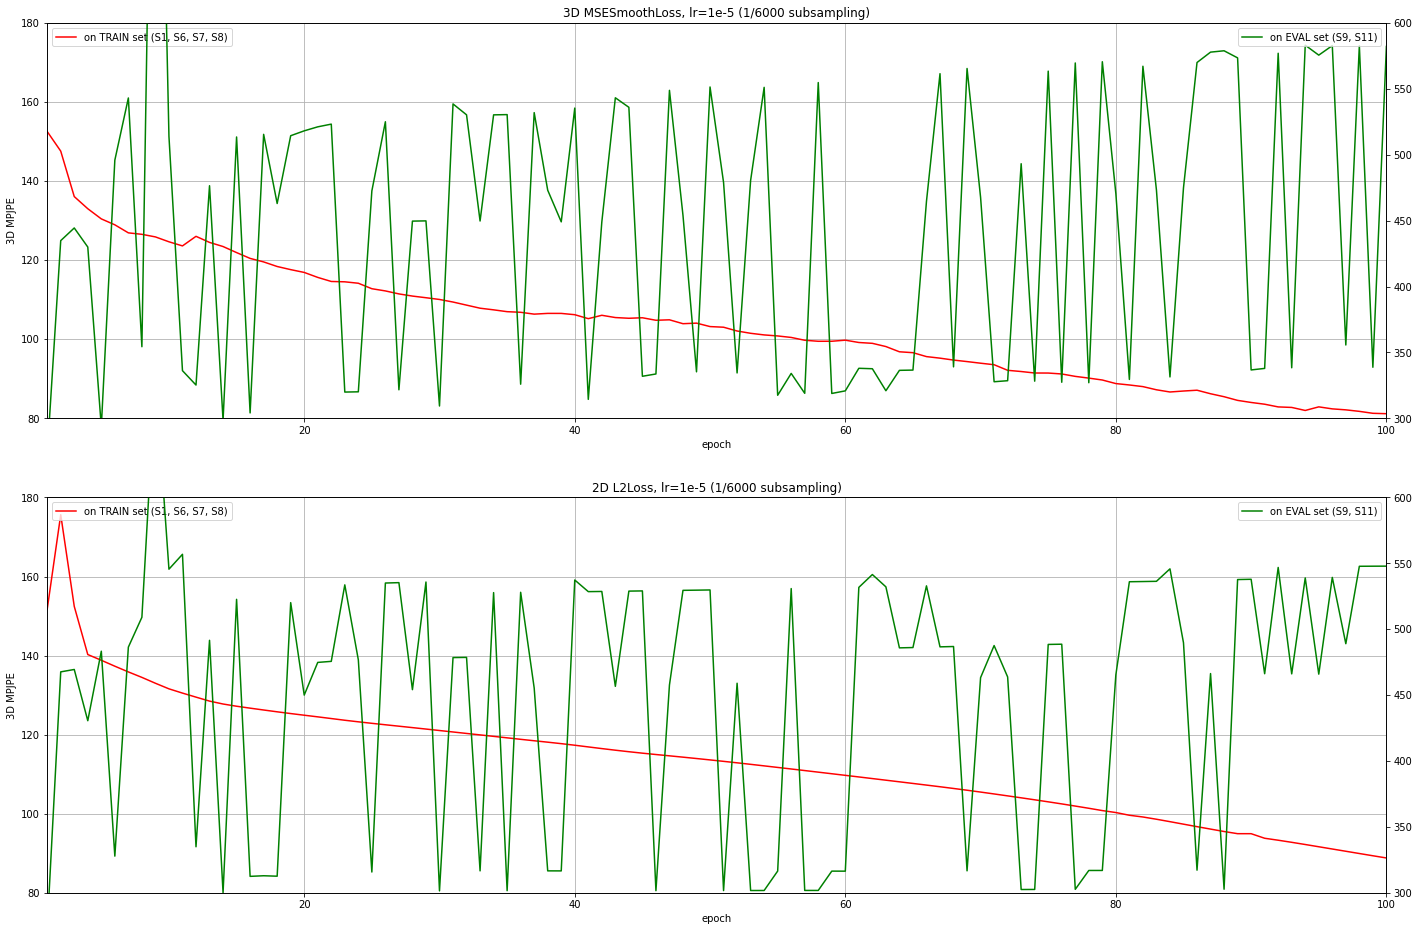

In [53]:
fig, ax = get_figa(2, 1)

for axis, metrics in zip(
        ax.ravel(),
        [experiments['04_08_13_09'], experiments['04_09_12_01']]
    ):
    plot_metrics(axis, metrics)

    axis.set_xlim([1, 100])

    axis.grid(True)
    axis.set_ylabel('3D MPJPE')
    axis.set_xlabel('epoch')
    
    axis.set_title(metrics['title'])

In [38]:
a = torch.zeros(17, 2)
b = torch.zeros(17,2)

In [40]:
a.unsqueeze(0).shape

torch.Size([1, 17, 2])